## Weekly Working Gas in Underground Storage (Lower 48, Bcf) — Weekly → Daily (Business-Day)

We fetch the EIA weekly storage series (facet `NW2_EPG0_SWO_R48_BCF`) via the Natural Gas → Storage (weekly) v2 API.  
Steps: fetch + paginate → clean → upsample to daily (forward-fill) → convert to business-day → save files.

In [9]:
# --- Config ---
EIA_API_KEY   = "8TyQKfFimNgTg1rHsnQMcXp1cqJkmgtwepZQ6FPB"
START_DATE    = "2010-01-01"  # keep consistent with the rest of your dataset

STOR_RAW_CSV   = "storage_weekly_raw_v2.csv"
STOR_DAILY_CSV = "storage_daily_ffill.csv"
STOR_BIZ_CSV   = "storage_biz.csv"

# --- Imports ---
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
def fetch_weekly_storage(api_key, start=START_DATE, page_len=5000):
    """
    Fetch Weekly Lower 48 Working Gas in Underground Storage (Bcf) from EIA v2.
    Route: https://api.eia.gov/v2/natural-gas/stor/wkly/data
    Facet: {"series": ["NW2_EPG0_SWO_R48_BCF"]}
    Returns: DataFrame with columns [date, storage_bcf]
    """
    base_url = "https://api.eia.gov/v2/natural-gas/stor/wkly/data"
    rows_all, offset = [], 0

    while True:
        payload = {
            "frequency": "weekly",
            "data": ["value"],
            "facets": {"series": ["NW2_EPG0_SWO_R48_BCF"]},
            "start": start,  # 'YYYY-MM-DD'
            "sort": [{"column": "period", "direction": "asc"}],
            "offset": offset,
            "length": page_len
        }
        r = requests.post(base_url, params={"api_key": api_key}, json=payload, timeout=30)
        if r.status_code != 200:
            print("Status:", r.status_code, "\nResponse:", r.text[:400])
            r.raise_for_status()

        resp = r.json()["response"]
        rows = resp.get("data", [])
        rows_all.extend(rows)

        total = resp.get("total", 0)
        try:
            total = int(total)
        except Exception:
            total = len(rows_all)

        offset += page_len
        if offset >= total or not rows:
            break

    df = pd.DataFrame(rows_all)
    df["date"] = pd.to_datetime(df["period"], errors="coerce")
    df["storage_bcf"] = pd.to_numeric(df["value"], errors="coerce")
    df = df[["date", "storage_bcf"]].sort_values("date").reset_index(drop=True)
    return df

# Fetch + save raw
df_stor = fetch_weekly_storage(EIA_API_KEY)
df_stor.to_csv(STOR_RAW_CSV, index=False)
df_stor.head(), df_stor.tail(), df_stor.shape

(        date  storage_bcf
 0 2010-01-01         3117
 1 2010-01-08         2850
 2 2010-01-15         2607
 3 2010-01-22         2521
 4 2010-01-29         2406,
           date  storage_bcf
 825 2025-10-24         3882
 826 2025-10-31         3915
 827 2025-11-07         3960
 828 2025-11-14         3946
 829 2025-11-21         3935,
 (830, 2))

### Upsample weekly → daily and convert to business-day (forward-fill)

In [11]:
# Weekly -> Daily calendar days
daily_idx = pd.DataFrame({"date": pd.date_range(df_stor.date.min(), df_stor.date.max(), freq="D")})
df_stor_daily = daily_idx.merge(df_stor, on="date", how="left").ffill()
df_stor_daily.to_csv(STOR_DAILY_CSV, index=False)

# Daily -> Business days
biz_idx = pd.DataFrame({"date": pd.bdate_range(df_stor_daily.date.min(), df_stor_daily.date.max())})
df_stor_biz = biz_idx.merge(df_stor_daily, on="date", how="left").ffill()
df_stor_biz.to_csv(STOR_BIZ_CSV, index=False)

df_stor_biz.head(), df_stor_biz.tail(), df_stor_biz.shape

(        date  storage_bcf
 0 2010-01-01       3117.0
 1 2010-01-04       3117.0
 2 2010-01-05       3117.0
 3 2010-01-06       3117.0
 4 2010-01-07       3117.0,
            date  storage_bcf
 4141 2025-11-17       3946.0
 4142 2025-11-18       3946.0
 4143 2025-11-19       3946.0
 4144 2025-11-20       3946.0
 4145 2025-11-21       3935.0,
 (4146, 2))

### Visualise plot of Storage

Produce Simple line plot of data collected to confirm data is correct.

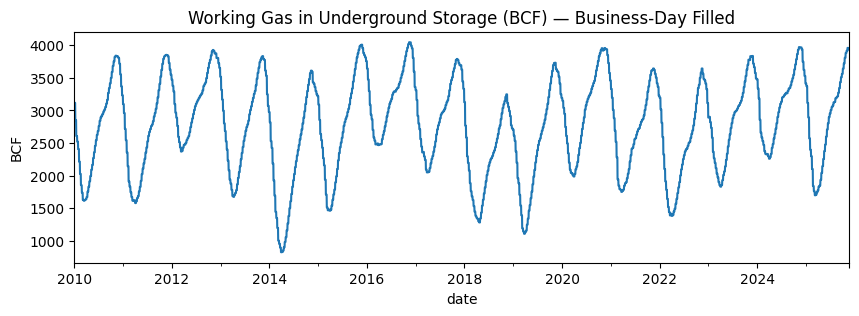

In [13]:
df_stor_biz.set_index("date")["storage_bcf"].plot(figsize=(10,3))
plt.title("Working Gas in Underground Storage (BCF) — Business-Day Filled")
plt.ylabel("BCF")
plt.show()